We will train regression models (Linear Regression and Decision Tree) on the preprocessed dataset and evaluate their performance on training, validation, and test sets.

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_extraction import FeatureHasher
import math
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')

# Constants
RANDOM_STATE = 42
N_SPLITS = 10
DATA_PATH = '../data/train.csv'
PCA_N_COMPONENT = 0.9
N_FEATURES = 48

In [211]:
# Step 1: Load data
df = pd.read_csv(DATA_PATH)
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print('\nSalePrice summary:')
print(df['SalePrice'].describe())

Loaded dataset with 1460 rows and 80 columns

SalePrice summary:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [212]:
# Step 2: 60-20-20 split (train / val / test)
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

print(f"Train: {X_train.shape[0]} rows")
print(f"Validation: {X_val.shape[0]} rows")
print(f"Test: {X_test.shape[0]} rows")

Train: 876 rows
Validation: 292 rows
Test: 292 rows


In [213]:
# Step 3: Identify numeric and categorical features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

Numeric features (36): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Gar

In [214]:
# Step 4: Combine train + val for cross-validation
X_cv = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_cv = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
print(f"Combined train+val for CV: {X_cv.shape[0]} rows")

Combined train+val for CV: 1168 rows


In [215]:
# Step 5: PCA + Ridge pipeline with per-fold preprocessing and CV
from sklearn.model_selection import KFold
alphas = [1e-6,1e-4,1e-3,1e-2,1e-1,1,10,100,1e3,1e4]
cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

cv_rmse_lr = []
cv_mae_lr = []
cv_r2_lr = []
fold = 0

print('Running CV with PCA + Ridge pipeline...')
for train_idx, val_idx in cv.split(X_cv):
    fold += 1
    X_tr_raw = X_cv.iloc[train_idx].reset_index(drop=True)
    y_tr = y_cv.iloc[train_idx].reset_index(drop=True)
    X_va_raw = X_cv.iloc[val_idx].reset_index(drop=True)
    y_va = y_cv.iloc[val_idx].reset_index(drop=True)

    # Preprocessor: impute median -> scale -> PCA for numeric; hashing for categorical
    numeric_transform = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('pca', PCA(n_components=PCA_N_COMPONENT, svd_solver='full'))
    ])
    # categorical hashing pipeline: impute -> convert to dicts -> FeatureHasher -> to dense
    categorical_transform = Pipeline([ ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), ('to_dict', FunctionTransformer(lambda X: pd.DataFrame(X, columns=categorical_cols).astype(str).to_dict(orient='records'), validate=False)), ('hasher', FeatureHasher(n_features=N_FEATURES, input_type='dict')), ('to_dense', FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)) ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transform, numeric_cols),
        ('cat', categorical_transform, categorical_cols)
    ], remainder='drop')

    # Full pipeline with RidgeCV inside
    ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=10)
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('reg', ridge_cv)
    ])

    # Fit
    pipeline.fit(X_tr_raw, y_tr)

    # Predict
    y_va_pred = pipeline.predict(X_va_raw)

    # Metrics
    rmse_val = np.sqrt(mean_squared_error(y_va, y_va_pred))
    mae_val = mean_absolute_error(y_va, y_va_pred)
    r2_val = r2_score(y_va, y_va_pred)

    cv_rmse_lr.append(rmse_val)
    cv_mae_lr.append(mae_val)
    cv_r2_lr.append(r2_val)

print('\nCV summary:')
print(f"RMSE mean = {np.mean(cv_rmse_lr):.2f}, std = {np.std(cv_rmse_lr):.2f}")
print(f"MAE  mean = {np.mean(cv_mae_lr):.2f}, std = {np.std(cv_mae_lr):.2f}")
print(f"R^2  mean = {np.mean(cv_r2_lr):.4f}, std = {np.std(cv_r2_lr):.4f}")

Running CV with PCA + Ridge pipeline...

CV summary:
RMSE mean = 50092.84, std = 5957.74
MAE  mean = 34622.71, std = 3358.22
R^2  mean = 0.6150, std = 0.0679


In [216]:
# Step 5a: Use validation set to select best alpha (model selection)
print('Using validation set for model selection (finding best alpha)...')

# Build preprocessor once
numeric_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=PCA_N_COMPONENT, svd_solver='full'))
])
categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_dict', FunctionTransformer(lambda X: pd.DataFrame(X, columns=categorical_cols).astype(str).to_dict(orient='records'), validate=False)),
    ('hasher', FeatureHasher(n_features=N_FEATURES, input_type='dict')),
    ('to_dense', FunctionTransformer(lambda X: X.toarray(), accept_sparse=True))
])
preprocessor_val = ColumnTransformer([
    ('num', numeric_transform, numeric_cols),
    ('cat', categorical_transform, categorical_cols)
], remainder='drop')

# Train different Ridge models with different alphas on training set, evaluate on validation set
val_results = []
for alpha in alphas:
    pipe = Pipeline([
        ('pre', preprocessor_val),
        ('reg', Ridge(alpha=alpha))
    ])
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_results.append({'alpha': alpha, 'val_rmse': val_rmse})

val_df = pd.DataFrame(val_results)
best_alpha = val_df.loc[val_df['val_rmse'].idxmin(), 'alpha']
best_val_rmse = val_df.loc[val_df['val_rmse'].idxmin(), 'val_rmse']
print(f'Best alpha selected by validation set: {best_alpha} (Val RMSE: {best_val_rmse:.2f})')
print(val_df)

Using validation set for model selection (finding best alpha)...
Best alpha selected by validation set: 1e-06 (Val RMSE: 60325.98)
          alpha      val_rmse
0      0.000001  60325.984703
1      0.000100  60325.984758
2      0.001000  60325.985263
3      0.010000  60325.990914
4      0.100000  60326.107461
5      1.000000  60332.567895
6     10.000000  60622.315617
7    100.000000  63867.427540
8   1000.000000  75579.620342
9  10000.000000  91778.091123


Generating learning curve (J_train vs J_validation)...


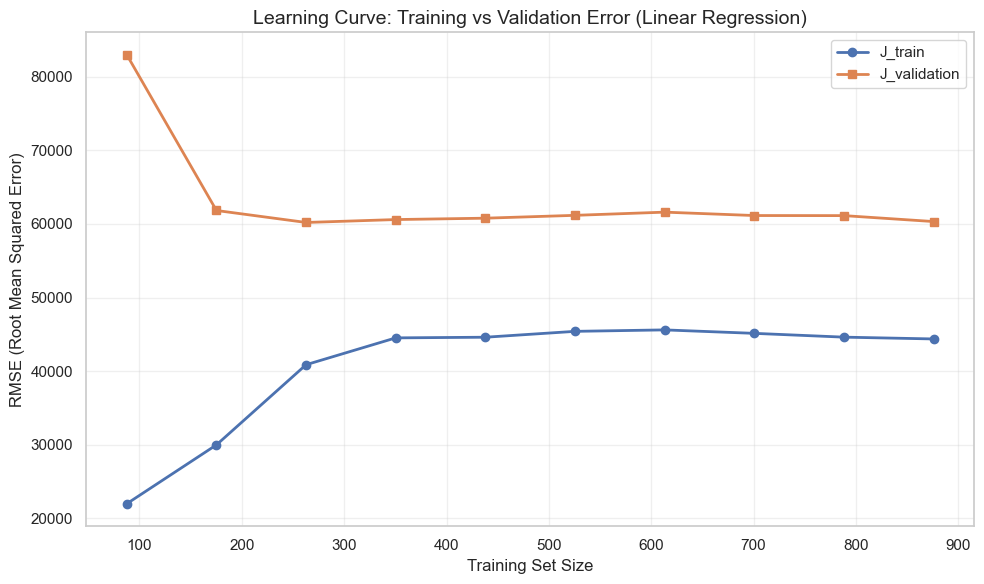

Model appears well-fitted


In [217]:
# Step 5b: Learning curve to detect overfitting/underfitting

# Use the best alpha from validation set
best_pipe = Pipeline([
    ('pre', ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
            ('pca', PCA(n_components=PCA_N_COMPONENT, svd_solver='full'))
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('to_dict', FunctionTransformer(lambda X: pd.DataFrame(X, columns=categorical_cols).astype(str).to_dict(orient='records'), validate=False)),
            ('hasher', FeatureHasher(n_features=N_FEATURES, input_type='dict')),
            ('to_dense', FunctionTransformer(lambda X: X.toarray(), accept_sparse=True))
        ]), categorical_cols)
    ], remainder='drop')),
    ('reg', Ridge(alpha=best_alpha))
])

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    n_samples = int(size * len(X_train))
    X_subset = X_train.iloc[:n_samples]
    y_subset = y_train.iloc[:n_samples]
    
    pipe_temp = clone(best_pipe)
    pipe_temp.fit(X_subset, y_subset)
    
    y_train_pred = pipe_temp.predict(X_subset)
    y_val_pred = pipe_temp.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_subset, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_errors, 'o-', label='J_train', linewidth=2, markersize=6)
plt.plot(train_sizes * len(X_train), val_errors, 's-', label='J_validation', linewidth=2, markersize=6)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE (Root Mean Squared Error)', fontsize=12)
plt.title('Learning Curve: Training vs Validation Error (Linear Regression)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [218]:
# Step 6: Train final PCA+Ridge pipeline on full train+val and evaluate on test
numeric_transform_final = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=PCA_N_COMPONENT, svd_solver='full'))
])
categorical_transform_final = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_dict', FunctionTransformer(lambda X: pd.DataFrame(X, columns=categorical_cols).astype(str).to_dict(orient='records'), validate=False)),
    ('hasher', FeatureHasher(n_features=N_FEATURES, input_type='dict')),
    ('to_dense', FunctionTransformer(lambda X: X.toarray(), accept_sparse=True))
])
final_preprocessor = ColumnTransformer([
    ('num', numeric_transform_final, numeric_cols),
    ('cat', categorical_transform_final, categorical_cols)
], remainder='drop')

final_ridge = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=10)
final_pipeline = Pipeline([
    ('pre', final_preprocessor),
    ('reg', final_ridge)
])

final_pipeline.fit(X_cv, y_cv)
final_alpha = final_pipeline.named_steps['reg'].alpha_
print(f"Trained final pipeline on full train+val. Selected alpha = {final_alpha}")

# Evaluate on held-out test
y_test_pred = final_pipeline.predict(X_test)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae_lr = mean_absolute_error(y_test, y_test_pred)
test_r2_lr = r2_score(y_test, y_test_pred)
print('\nFinal evaluation on held-out test split:')
print(f"Test RMSE = {test_rmse_lr:.2f}")
print(f"Test MAE  = {test_mae_lr:.2f}")
print(f"Test R^2  = {test_r2_lr:.4f}")

Trained final pipeline on full train+val. Selected alpha = 10.0

Final evaluation on held-out test split:
Test RMSE = 43252.96
Test MAE  = 33838.81
Test R^2  = 0.6175


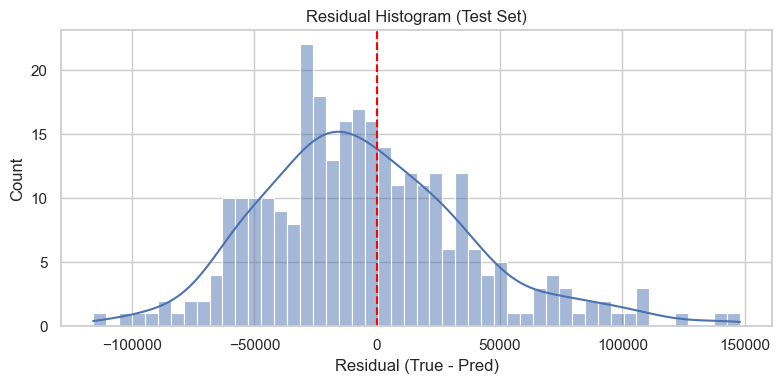

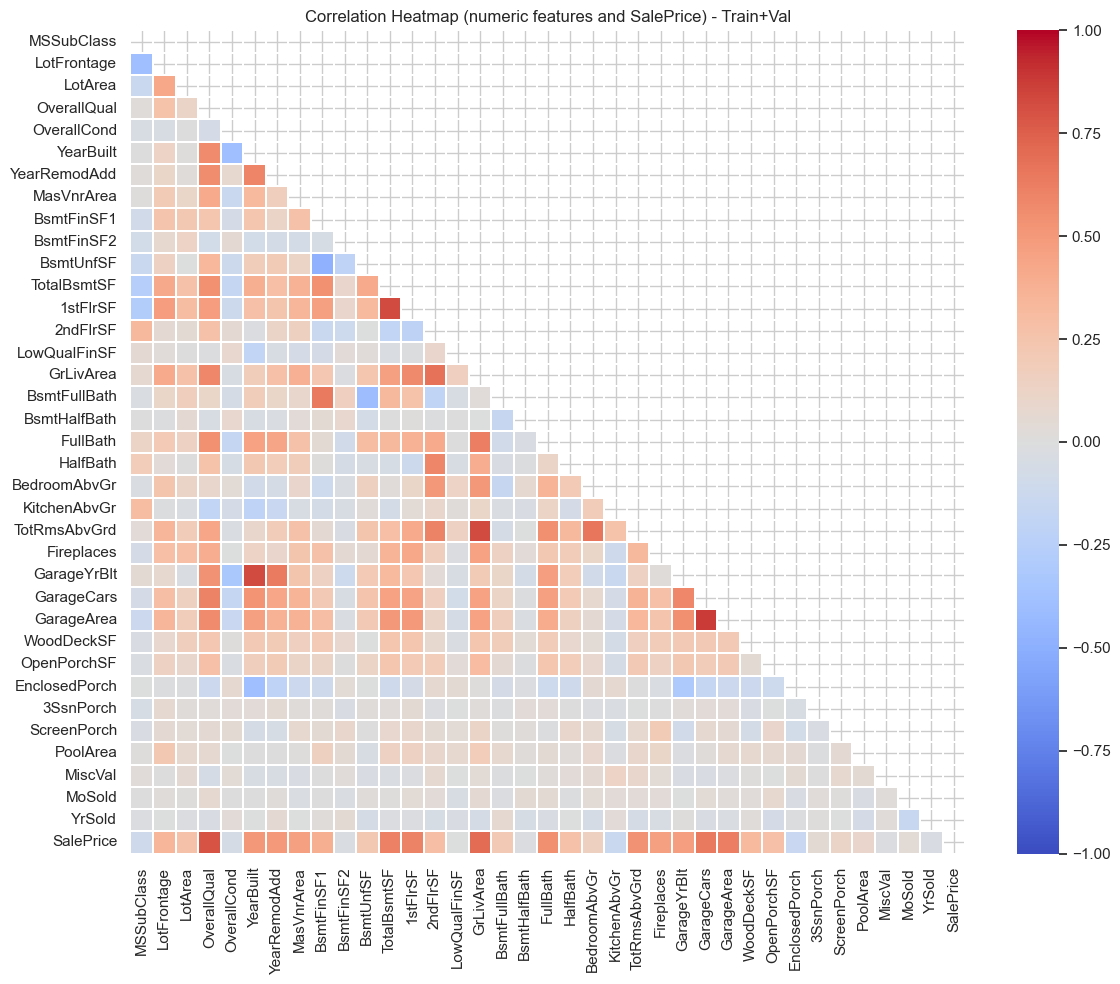

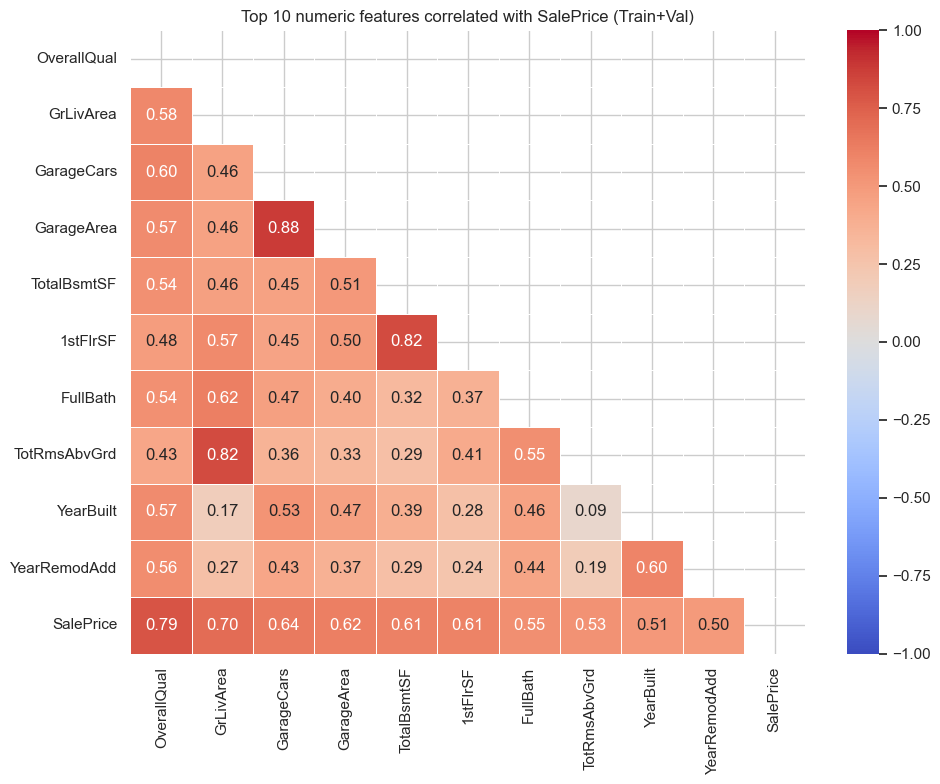

In [219]:
#Linear Regression Visualizations

# Residual histogram
residuals = y_test - y_test_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True, color='C0')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residual (True - Pred)')
plt.title('Residual Histogram (Test Set)')
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features (train+val)
df_corr = pd.concat([X_cv[numeric_cols].reset_index(drop=True), y_cv.reset_index(drop=True)], axis=1)
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.1)
plt.title('Correlation Heatmap (numeric features and SalePrice) - Train+Val')
plt.tight_layout()
plt.show()

# Select top-10 numeric features most correlated with SalePrice and plot their correlation heatmap
# (uses numeric_cols_filtered, X_cv and y_cv from earlier)

# 1) compute absolute correlations with target and pick top 10
corr_with_target = X_cv[numeric_cols].corrwith(y_cv).abs().sort_values(ascending=False)
top_features = corr_with_target.head(10).index.tolist()

# 2) build dataframe with those top features + SalePrice
df_corr = pd.concat([X_cv[top_features].reset_index(drop=True), y_cv.reset_index(drop=True)], axis=1)

# 3) correlation matrix and heatmap (masked upper triangle), annotated
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    square=False
)
plt.title('Top 10 numeric features correlated with SalePrice (Train+Val)')
plt.tight_layout()
plt.show()

In [220]:
# Decision Tree Regression
# RidgeTextFeature remains useful for compressing text info into a single regularized feature
class RidgeTextFeature(BaseEstimator, TransformerMixin):
    def __init__(self, alphas=(0.1, 1.0, 10.0)):
        self.alphas = alphas
        self.model_ = None
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("RidgeTextFeature requires y in fit(X, y)")
        self.model_ = RidgeCV(alphas=self.alphas, store_cv_values=False)
        self.model_.fit(X, y)
        return self
    def transform(self, X):
        if self.model_ is None:
            raise ValueError("Transformer not fitted yet")
        preds = self.model_.predict(X)
        return np.array(preds).reshape(-1, 1)
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X)

In [221]:
# Step 1: Build regularized preprocessing pipelines with hash-encoding for categorical features
# Numeric pipeline: impute -> robust scale -> variance threshold -> PCA (retain 95% variance)
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler()),
    ('var_thresh', VarianceThreshold(threshold=1e-3)),
    ('pca', PCA(n_components=PCA_N_COMPONENT, svd_solver='full', random_state=42))
])

# Categorical pipeline: impute -> join category tokens per row -> HashingVectorizer -> SVD
def join_categorical_columns(X):
    # X is a 2D array-like of categorical columns
    df_cat = pd.DataFrame(X, columns=[f'cat_{i}' for i in range(X.shape[1])])
    # Ensure strings and replace missing marker
    df_cat = df_cat.fillna('Missing').astype(str)
    # Join with space so HashingVectorizer treats each token separately
    joined = df_cat.apply(lambda row: ' '.join([f"{col}={val}" for col, val in zip(df_cat.columns, row)]), axis=1)
    return joined.values

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_str_join', FunctionTransformer(join_categorical_columns, validate=False)),
    ('hash', HashingVectorizer(n_features=2**10, alternate_sign=False)),
    ('svd', TruncatedSVD(n_components=50, random_state=42))
])

# Text pipeline (hash -> SVD) and Ridge summary branch
text_svd_pipeline = Pipeline([
    ('to1d', FunctionTransformer(lambda x: x.ravel(), validate=False)),
    ('hash', HashingVectorizer(n_features=2**10, alternate_sign=False)),
    ('svd', TruncatedSVD(n_components=50, random_state=42))
])
text_ridge_pipeline = Pipeline([
    ('to1d', FunctionTransformer(lambda x: x.ravel(), validate=False)),
    ('hash', HashingVectorizer(n_features=2**10, alternate_sign=False)),
    ('svd', TruncatedSVD(n_components=50, random_state=42)),
    ('ridge_feat', RidgeTextFeature(alphas=(0.01, 0.1, 1.0, 10.0)))
])

transformers = []
if numeric_cols:
    transformers.append(('num', numeric_pipeline, numeric_cols))
if categorical_cols:
    # note: categorical_pipeline expects a 2D array of categorical columns
    transformers.append(('cat', categorical_pipeline, categorical_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# After preprocessing, add a SelectFromModel using Ridge to further regularize/select features
feature_selector = SelectFromModel(estimator=Ridge(alpha=1.0), threshold='median')

# Final pipeline: preprocessing -> feature selection (Ridge-based) -> regressor
model_pipeline = Pipeline([
    ('pre', preprocessor),
    ('feat_sel', feature_selector),
    ('reg', DecisionTreeRegressor(random_state=42))
])
print('Constructed regularized preprocessing + pipeline with categorical hashing')

Constructed regularized preprocessing + pipeline with categorical hashing


In [222]:
# Step 2: Prepare tuning set (train + val) and GridSearchCV using our predefined split
X_tune = pd.concat([X_train, X_val]).reset_index(drop=True)
y_tune = pd.concat([y_train, y_val]).reset_index(drop=True)
n_train = len(X_train)
train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + len(X_val))
cv = [(train_idx, val_idx)]

param_grid = {
    'reg__max_depth': [None, 6, 10],
    'reg__min_samples_leaf': [1, 5, 10]
}
gs = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    refit=True
)
print('GridSearch prepared')

GridSearch prepared


In [223]:
# Step 3: Fit grid search and compute average RMSE across the CV set for the best estimator
gs.fit(X_tune, y_tune)
best_params = gs.best_params_

# Compute CV scores for the best estimator across the predefined cv folds
# Using cross_val_score ensures we get per-fold scores (even if cv is a list of splits)
best_estimator = gs.best_estimator_
cv_scores = cross_val_score(best_estimator, X_tune, y_tune, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
rmse_per_fold = np.sqrt(-cv_scores)
avg_cv_rmse_dt = rmse_per_fold.mean()

neg_mae_scores = cross_val_score(
    best_estimator,
    X_tune,
    y_tune,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

mae_per_fold = -neg_mae_scores
avg_cv_mae_dt = mae_per_fold.mean()
std_cv_mae = mae_per_fold.std()

print(f'Average CV RMSE across the CV set: {avg_cv_rmse_dt:.4f}')

print(f"Average CV MAE across the CV set: {avg_cv_mae_dt:.4f}")

Fitting 1 folds for each of 9 candidates, totalling 9 fits


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.p

Average CV RMSE across the CV set: 58920.8775
Average CV MAE across the CV set: 37470.2496


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_

In [224]:
# Step 4: Evaluate on test set
best_model = gs.best_estimator_
y_test_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
cv_rmse_dt = math.sqrt(mse)
cv_mae_dt = mean_absolute_error(y_test, y_test_pred)
cv_r2_dt = r2_score(y_test, y_test_pred)
print('Test RMSE:', round(cv_rmse_dt, 4))
print('Test MAE:', round(cv_mae_dt, 4))
print('Test R2:', round(cv_r2_dt, 4))

Test RMSE: 45267.0029
Test MAE: 32170.9766
Test R2: 0.581


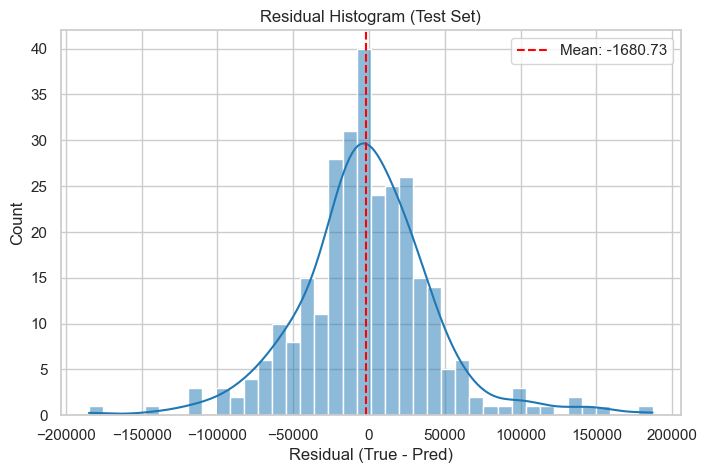

Residual mean: -1680.7251371105076 std: 45313.44824398102


In [225]:
# Decision Tree Visualizations
# Residual histogram
residuals = y_test - y_test_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=40, color='tab:blue')
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
plt.title('Residual Histogram (Test Set)')
plt.xlabel('Residual (True - Pred)')
plt.legend()
plt.show()
print('Residual mean:', residuals.mean(), 'std:', residuals.std())

In [226]:
# Step 11: Summary
print('=' * 60)
print('SUMMARY')
print('=' * 60)
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Model: Linear Regression")
print(f"CV RMSE: {np.mean(cv_rmse_lr):.4f}")
print(f"CV MAE: {np.mean(cv_mae_lr):.4f}")
print(f"Test RMSE: {test_rmse_lr:.4f}")
print(f"Test MAE:  {test_mae_lr:.4f}")
print(f"Test R^2:  {test_r2_lr:.4f}")
print(f"Model: Decision Tree Regression")
print(f"CV RMSE: {avg_cv_rmse_dt:.4f}")
print(f"CV MAE: {avg_cv_mae_dt:.4f}")
print(f"Test RMSE: {cv_rmse_dt:.4f}")
print(f"Test MAE:  {cv_mae_dt:.4f}")
print(f"Test R^2:  {cv_r2_dt:.4f}")
print('=' * 60)

SUMMARY
Numeric features: 36
Categorical features: 43
Training samples: 876
Validation samples: 292
Test samples: 292
Model: Linear Regression
CV RMSE: 50092.8415
CV MAE: 34622.7059
Test RMSE: 43252.9638
Test MAE:  33838.8095
Test R^2:  0.6175
Model: Decision Tree Regression
CV RMSE: 58920.8775
CV MAE: 37470.2496
Test RMSE: 45267.0029
Test MAE:  32170.9766
Test R^2:  0.5810
